## imports


In [1]:
%env HSA_OVERRIDE_GFX_VERSION=10.3.0
import re

import pandas as pd
import numpy as np

from gensim.models import Word2Vec, KeyedVectors, FastText, fasttext

import spacy

from sklearn.preprocessing import LabelBinarizer

from unidecode import unidecode
import unicodedata as ud
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import torch
import torch.nn as nn 

import torch.nn.functional as F

from sklearn.metrics import f1_score

import optuna

from sklearn.model_selection import KFold

from sklearn.manifold import TSNE

from sklearn.metrics import ConfusionMatrixDisplay

from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

from itertools import cycle

# variable to control if we want to use t-sne to visualize the embeddings
# change it to True if you want to use t-sne
tnse = False

# variable to control if we want to use optuna to tune the hyperparameters
# change it to True if you want to use optuna
use_optuna = False


env: HSA_OVERRIDE_GFX_VERSION=10.3.0


### Load our model

In [2]:
Word2VecModel = KeyedVectors.load_word2vec_format('/kaggle/input/mymodel/cc.el.300.vec')

# Read Data

In [3]:
TrainSet = pd.read_csv('/kaggle/input/ys19-2023-assignment-2/train_set.csv')
ValidationSet = pd.read_csv('/kaggle/input/ys19-2023-assignment-2/valid_set.csv')
TestSet = pd.read_csv('/kaggle/input/ys19-2023-assignment-2/test_set.csv')

In [4]:
#drop useless columns
Xtrain = TrainSet.drop(["Sentiment", "New_ID"], axis=1)
Xval = ValidationSet.drop(["Sentiment", "New_ID"], axis=1)
Xtest = TestSet.drop(["New_ID"], axis=1)

# concat Text and Party to Text and Drop Party column
Xtrain["Text"] = Xtrain["Text"] + " " + Xtrain["Party"]
Xval["Text"] = Xval["Text"] + " " + Xval["Party"]
Xtest["Text"] = Xtest["Text"] + " " + Xtest["Party"]

Xtrain = Xtrain.drop(["Party"], axis=1)
Xval = Xval.drop(["Party"], axis=1)
Xtest = Xtest.drop(["Party"], axis=1)

#Create Ytrain and Yval
Ytrain = TrainSet[["Sentiment"]].copy()
Yval = ValidationSet[["Sentiment"]].copy()

# Copy Xtrain and Xval to new variables (helpful for Brute Force Case)
Xtrain_without_preprocess = Xtrain.copy()
Xval_without_preprocess = Xval.copy()

## Make Ytrain and Yval one hot encoded

In [5]:
encoder = LabelBinarizer()
encoder.fit(Ytrain)
Ytrain = encoder.transform(Ytrain)
Yval = encoder.transform(Yval)

# WordCloud

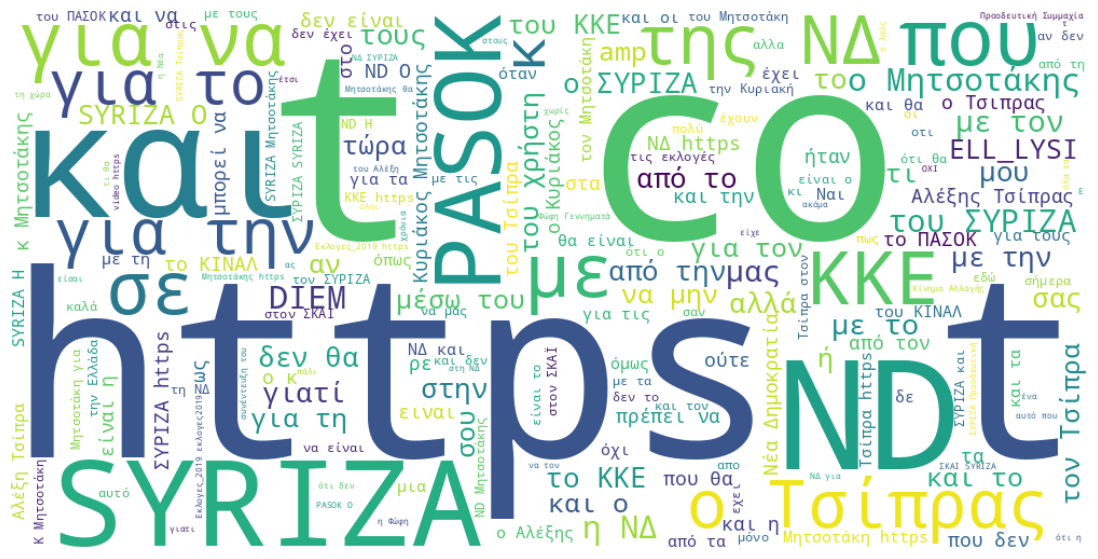

In [6]:
# Concatenate the text data from the column 'Text'
column_data = ' '.join(Xtrain['Text'])

# Create a wordcloud object before cleaning 
wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate(column_data)

# Plot the wordcloud
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Tokens Frequency Diagram

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


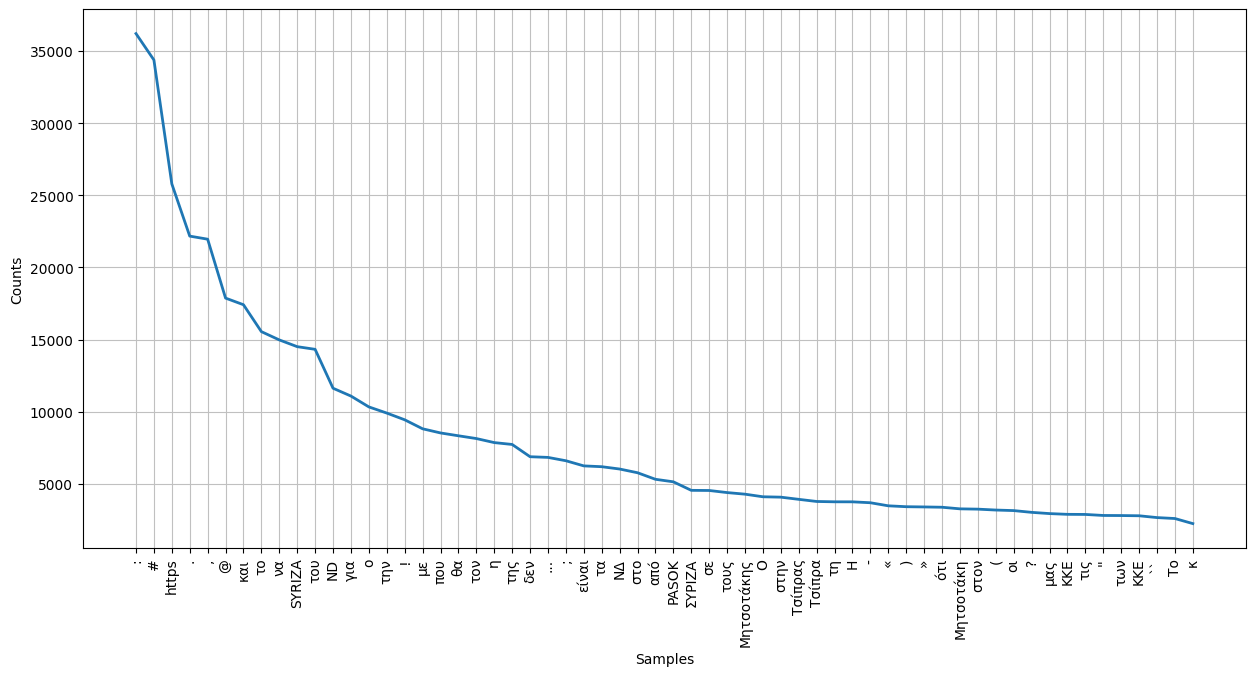

In [7]:
# Create token frequency diagram before cleaning

nltk.download('punkt')
tokens = [word_tokenize(word, language='greek') for word in Xtrain['Text']]
token_frequency = FreqDist(np.hstack(tokens))
plt.figure(figsize=(15,7))
token_frequency.plot(60, cumulative=False)

# PreProcessing

In [8]:
# Data Preprocessing
!python -m spacy download el_core_news_sm
nlp = spacy.load("el_core_news_sm")

# remove accents
def remove_accent(text):
    d= {ord('\N{COMBINING ACUTE ACCENT}'):None}
    X_without_accents=ud.normalize('NFD',text).translate(d)
    return X_without_accents

def process_tweet(tweet):
    doc = nlp(tweet)
    tweet = ""
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and not token.like_url and len(token.lemma_)>1 and len(token)<15 and not token.pos_ == 'VERB':
            tweet += token.lemma_ + " "
    return tweet
           
#remove emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string) 

# remove emojis
Xtrain['Text'] = Xtrain['Text'].map(remove_emoji)
Xval['Text'] = Xval['Text'].map(remove_emoji)
Xtest['Text'] = Xtest['Text'].map(remove_emoji)

# remove stop words, punctuation, spaces, urls and lemmatize
Xtrain['Text'] = Xtrain['Text'].map(process_tweet)
Xval['Text'] = Xval['Text'].map(process_tweet)
Xtest['Text'] = Xtest['Text'].map(process_tweet)

# remove mentions
Xtrain['Text'] = Xtrain['Text'].map(lambda x: re.sub(r'@\S+', '', x))
Xval['Text'] = Xval['Text'].map(lambda x: re.sub(r'@\S+', '', x))
Xtest['Text'] = Xtest['Text'].map(lambda x: re.sub(r'@\S+', '', x))

# remove accents
Xtrain['Text'] = Xtrain['Text'].map(remove_accent)
Xval['Text'] = Xval['Text'].map(remove_accent)
Xtest['Text'] = Xtest['Text'].map(remove_accent)

# remove numbers
Xtrain['Text'] = Xtrain['Text'].map(lambda x: re.sub(r'\d+', '', x))
Xval['Text'] = Xval['Text'].map(lambda x: re.sub(r'\d+', '', x))
Xtest['Text'] = Xtest['Text'].map(lambda x: re.sub(r'\d+', '', x))

# remove & symbols
Xtrain['Text'] = Xtrain['Text'].map(lambda x: re.sub(r'%', '', x))
Xval['Text'] = Xval['Text'].map(lambda x: re.sub(r'%', '', x))
Xtest['Text'] = Xtest['Text'].map(lambda x: re.sub(r'%', '', x))

# remove dots and commas
Xtrain['Text'] = Xtrain['Text'].map(lambda x: re.sub(r'[.,]', '', x))
Xval['Text'] = Xval['Text'].map(lambda x: re.sub(r'[.,]', '', x))
Xtest['Text'] = Xtest['Text'].map(lambda x: re.sub(r'[.,]', '', x))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 61.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_sm')


# Word Cloud after Preprocess

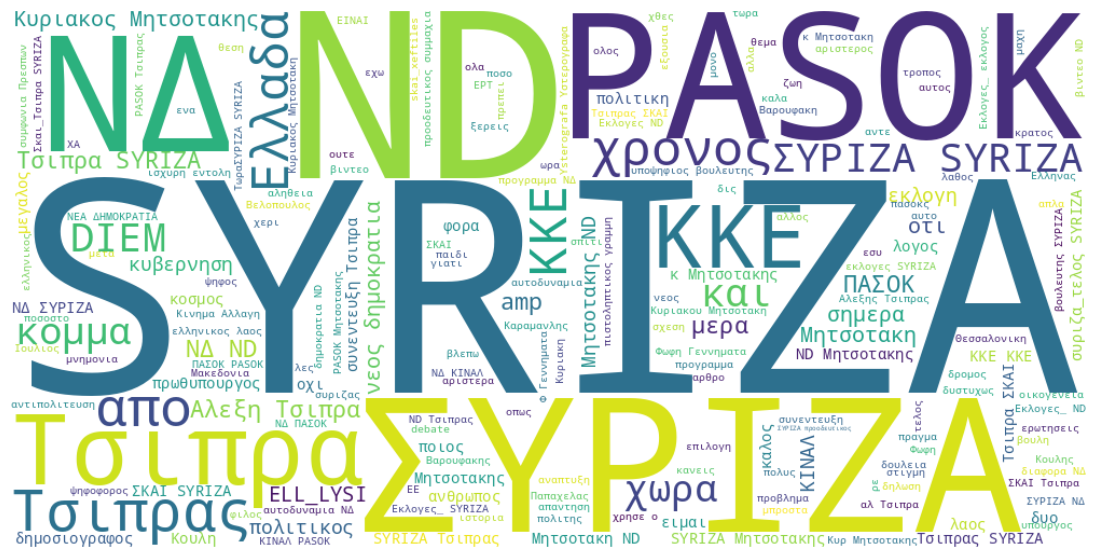

In [9]:
# Concatenate the text data from the column 'Text'
column_data = ' '.join(Xtrain['Text'])

# Create a wordcloud object after cleaning 
wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate(column_data)

# Plot the wordcloud
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Token Frequency Diagram after Preprocess

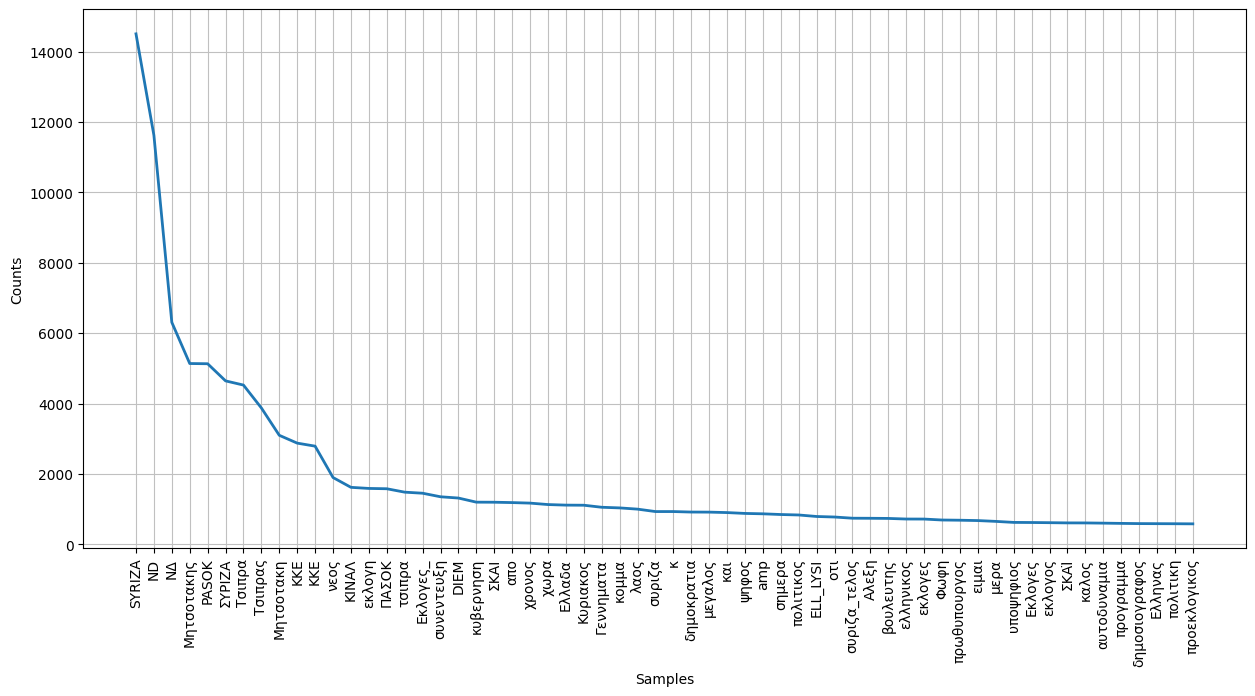

In [10]:
# Create token frequency diagram after cleaning

tokens = [word_tokenize(word, language='greek') for word in Xtrain['Text']]
token_frequency = FreqDist(np.hstack(tokens))
plt.figure(figsize=(15,7))
token_frequency.plot(60, cumulative=False)

# TSNE Visualization

In [11]:
def tnse_visualization(XVectorized,labels):
    #visualize with t-sne
    tsne = TSNE(n_components=2, random_state=0)
    XVectorized = tsne.fit_transform(XVectorized)

    x = []
    y = []
    for value in XVectorized:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10,10)) 
    plt.title('T-SNE Visualization')
    for i in range(50):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                        xy=(x[i], y[i]),
                        xytext=(2, 2),
                        textcoords='offset points',
                        ha='right',
                        va='bottom')
    plt.show()

# Vectorization

In [12]:
#each tweet is a vector occurs from the mean of the vectors of the words that compose it
def convert_tweet_to_vector(tweet):
    vector = np.zeros(Word2VecModel.vector_size)
    number = 0
    words = tweet.split()

    for word in words:
        try:
            vector = vector + Word2VecModel.get_vector(word)
            number = number + 1
        except:
            pass
        
    if(number != 0):
        vector /= number 
        
    
    return vector 


# Here is the vectorization with CBOW
# each tweet is a vector occurs from the mean of the vectors of the words that compose it(the vector of each word is the mean of the surrounding words)
def convert_tweet_to_vector_CBOW(tweet):
    vector = np.zeros(Word2VecModel.vector_size)
    number = 0
    words = tweet.split()

    for idx, word in enumerate(words):
        Window = []
        for neighbour in words[max(0, idx - 4):min(len(words), idx + 4)]:  
            if neighbour != word:  
                try:
                    Window.append(Word2VecModel.get_vector(neighbour))
                except KeyError:
                    pass

        if Window:
            vector = vector + np.mean(Window, axis=0)
            number = number + 1

    if number != 0:
        vector /= number

    return vector



# convert tweets to vectors
XtrainVectorized = Xtrain['Text'].map(convert_tweet_to_vector)
XtrainVectorized = np.array(XtrainVectorized.tolist())

XvalVectorized = Xval['Text'].map(convert_tweet_to_vector)
XvalVectorized = np.array(XvalVectorized.tolist())

XtestVectorized = Xtest['Text'].map(convert_tweet_to_vector)
XtestVectorized = np.array(XtestVectorized.tolist())

labels = []
#i want to give to each training sentence a name
for i in range(len(XtrainVectorized)):
    label = "sentence" + str(i)
    labels.append(label)
    
# visualize with t-sne
if tnse == True:
    tnse_visualization(XtrainVectorized,labels)


# convert tweets to vectors with CBOW
XtrainVectorized_CBOW = Xtrain['Text'].map(convert_tweet_to_vector_CBOW)
XtrainVectorized_CBOW = np.array(XtrainVectorized_CBOW.tolist())

XvalVectorized_CBOW = Xval['Text'].map(convert_tweet_to_vector_CBOW)
XvalVectorized_CBOW = np.array(XvalVectorized_CBOW.tolist())

# convert tweets to vectors (without having been preprocessed)
XtrainVectorized_without_preprocess = Xtrain_without_preprocess['Text'].map(convert_tweet_to_vector)
XtrainVectorized_without_preprocess = np.array(XtrainVectorized_without_preprocess.tolist())

XvalVectorized_without_preprocess = Xval_without_preprocess['Text'].map(convert_tweet_to_vector)
XvalVectorized_without_preprocess = np.array(XvalVectorized_without_preprocess.tolist())





In [13]:
def Save_to_tensors(XtrainVectorized, Ytrain, XvalVectorized, Yval, compute_unit):

    XtrainTensor = torch.tensor(XtrainVectorized, dtype=torch.float, device=compute_unit)
    YtrainTensor = torch.tensor(Ytrain, dtype=torch.float, device=compute_unit)

    XvalTensor = torch.tensor(XvalVectorized, dtype=torch.float, device=compute_unit)
    YvalTensor = torch.tensor(Yval, dtype=torch.float, device=compute_unit)
    
    return XtrainTensor, YtrainTensor, XvalTensor, YvalTensor



#choose device to train the model
compute_unit = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#seed for reproducibility
torch.manual_seed(42)

#save to tensors
XtrainTensor, YtrainTensor, XvalTensor, YvalTensor = Save_to_tensors(XtrainVectorized, Ytrain, XvalVectorized, Yval, compute_unit)
XtestTensor = torch.tensor(XtestVectorized, dtype=torch.float, device=compute_unit)
XtrainTensor_CBOW, YtrainTensor_CBOW, XvalTensor_CBOW, YvalTensor_CBOW = Save_to_tensors(XtrainVectorized_CBOW, Ytrain, XvalVectorized_CBOW, Yval, compute_unit)
XtrainTensor_without_preprocess, YtrainTensor, XvalTensor_without_preprocess, YvalTensor = Save_to_tensors(XtrainVectorized_without_preprocess, Ytrain, XvalVectorized_without_preprocess, Yval, compute_unit)

# Define the Neural Network

In [14]:
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, H3,H4,D_out,activation=None, dropout=0):
        super(Net, self).__init__()
        self.dropout1 = nn.Dropout(p=dropout)
        self.dropout2 = nn.Dropout(p=dropout)
        self.dropout3 = nn.Dropout(p=dropout)
        self.dropout4 = nn.Dropout(p=dropout)
        
        self.linear1 = nn.Linear(D_in, H1)
        self.activation1 = activation
        
        self.linear2 = nn.Linear(H1, H2)
        self.activation2 = activation
        
        self.linear3 = nn.Linear(H2, H3)
        self.activation3 = activation
        
        self.linear4 = nn.Linear(H3, H4)
        self.activation4 = activation
        
        self.linear5 = nn.Linear(H4,D_out)
        
    def forward(self, x):
        if self.activation1!=None:
            h1 = self.activation1(self.linear1(x))
            h1 = self.dropout1(h1)

            h2 = self.activation2(self.linear2(h1))
            h2 = self.dropout2(h2)

            h3 = self.activation3(self.linear3(h2))
            h3 = self.dropout3(h3)

            h4 = self.activation4(self.linear4(h3))
            h4 = self.dropout4(h4)
        else:
            h1 = self.dropout1(self.linear1(x))
            h2 = self.dropout2(self.linear2(h1))
            h3 = self.dropout3(self.linear3(h2))
            h4 = self.dropout4(self.linear4(h3))
            
        out = self.linear5(h4)
        return out

# Define the Brute Force Neural Network

In [15]:
class Brute_Force_Net(nn.Module):
    def __init__(self, D_in, H1,D_out):
        super(Brute_Force_Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, D_out)
        
    def forward(self, x):
        h1 = self.linear1(x)
        out = self.linear2(h1)
        return out

# ROC Curve and Confusion matrix

In [16]:
def plot_roc_curve_confusion_matrix(neural_network_model,XvalTensor,Yval):  
    
    with torch.no_grad():
        # predict the whole validation set
        neural_network_model.eval()
        Yval_predict = neural_network_model(XvalTensor)

    # ROC Curves

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(Yval.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(Yval[:, i], Yval_predict[:, i].cpu().numpy())
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    class_of_interest = ["POSITIVE", "NEGATIVE", "NEUTRAL"]
    plt.figure(figsize=(8, 6))
    
    for i in range(Yval.shape[1]):
        plt.plot(fpr[i], tpr[i], label=f'{class_of_interest[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.show()
    
    # Confusion Matrices 
    # we convert them to their original form
    Yval_init = encoder.inverse_transform(Yval)
    
    Yval_predict = torch.argmax(Yval_predict, axis=1)
    Ypred_init = np.zeros(shape=(Yval_predict.shape[0],3))
    Ypred_init[np.arange(len(Yval_predict.cpu())), Yval_predict.cpu()] = 1
    Ypred_init = encoder.inverse_transform(Ypred_init)

    ConfusionMatrixDisplay.from_predictions(Yval_init, Ypred_init, normalize="true",cmap=plt.cm.YlOrRd)
    plt.show()

# Plot Learning Curves

In [17]:
def plot_learning_curves(list_of_train_losses, list_of_valid_losses, list_of_f1_scores_train, list_of_f1_scores_valid, epoch_size_list):
    # plot validation and training F1 scores     
    plt.plot(epoch_size_list, list_of_f1_scores_train)
    plt.plot(epoch_size_list, list_of_f1_scores_valid)

    plt.xlabel("Epochs")
    plt.ylabel("F1 scores")
    plt.ylim(ymin=0.0, ymax=1.0)
    plt.legend(["Train", "Valid"])
    plt.show()

    # plot validation and training loss
    plt.plot(epoch_size_list, list_of_train_losses)
    plt.plot(epoch_size_list, list_of_valid_losses)
    
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.legend(["Train", "Valid"])
    plt.show()


# Train the model

In [18]:
def model_train(TrainDataloader, ValDataloader, neural_network_model, loss_func, optimizer, compute_unit,epochs=50,k_fold=False):
    list_of_f1_scores_train = []
    list_of_f1_scores_valid = []

    list_of_train_losses = []
    list_of_valid_losses = []

    for epoch in range(epochs):
        TrainBatchLosses = []
        ValBatchLosses = []

        ValPredictions = []
        ValTrueLabels = []

        TrainPredictions = []
        TrainTrueLabels = []

        # Training phase
        for XtrainBatch, YtrainBatch in TrainDataloader:
            
            XtrainBatch = XtrainBatch.to(compute_unit)
            YtrainBatch = YtrainBatch.to(compute_unit)
            
            # predict each XtrainBatch
            YtrainPred = neural_network_model(XtrainBatch)
            TrainLoss = loss_func(YtrainPred, YtrainBatch)
        
            TrainLoss.backward()
            optimizer.step()
            optimizer.zero_grad()

            TrainBatchLosses.append(TrainLoss.item())

            YtrainPred = YtrainPred.cpu()
            YtrainBatch = YtrainBatch.cpu()
            
            # Total Training Predictions and True Labels every epoch
            TrainPredictions.extend(YtrainPred.argmax(axis=1).tolist())
            TrainTrueLabels.extend(YtrainBatch.argmax(axis=1).tolist())
            
        
        # Validation phase
        with torch.no_grad():
            
            neural_network_model.eval()
            
            for XvalBatch, YvalBatch in ValDataloader:
                
                XvalBatch = XvalBatch.to(compute_unit)
                YvalBatch = YvalBatch.to(compute_unit)

                # predict each XvalBatch              
                YvalPred = neural_network_model(XvalBatch)
                
                ValLoss = loss_func(YvalPred, YvalBatch)
                ValBatchLosses.append(ValLoss.item())
                
                YvalPred = YvalPred.cpu()
                YvalBatch = YvalBatch.cpu()
                
                # Total Validation Predictions and True Labels every epoch
                ValPredictions.extend(YvalPred.argmax(axis=1).tolist())
                ValTrueLabels.extend(YvalBatch.argmax(axis=1).tolist())
            
        
        #calculate f1 score for each epoch
        f1_train = f1_score(TrainTrueLabels,TrainPredictions, average='micro')
        f1_valid = f1_score(ValTrueLabels,ValPredictions, average='micro')
        
        # keep the F1 scores and the losses of every epoch in a list       
        list_of_f1_scores_train.append(f1_train)
        list_of_f1_scores_valid.append(f1_valid)
        
        list_of_train_losses.append(np.mean(TrainBatchLosses))
        list_of_valid_losses.append(np.mean(ValBatchLosses))
        
        if k_fold == False and use_optuna == False:
            print("Epoch: ", epoch + 1, " Train Loss: ", np.mean(TrainBatchLosses), " Validation Loss: ", np.mean(ValBatchLosses), " Train F1: ", f1_train, " Validation F1: ", f1_valid)

            
    #plot f1 and loss learning curves
    if k_fold == False and use_optuna == False:
        plot_learning_curves(list_of_train_losses, list_of_valid_losses, list_of_f1_scores_train, list_of_f1_scores_valid, range(1,epochs+1))

    return f1_valid,list_of_f1_scores_train,list_of_f1_scores_valid,list_of_train_losses,list_of_valid_losses

# Brute Force Model

Epoch:  1  Train Loss:  0.3016164770405122  Validation Loss:  0.26462721933678884  Train F1:  0.33884793884793885  Validation F1:  0.3297018348623853
Epoch:  2  Train Loss:  0.24719085139961974  Validation Loss:  0.2353963381270083  Train F1:  0.34040404040404043  Validation F1:  0.33256880733944955
Epoch:  3  Train Loss:  0.22983764247224386  Validation Loss:  0.22625863788331427  Train F1:  0.34212394212394215  Validation F1:  0.3358180428134557
Epoch:  4  Train Loss:  0.2244937799051794  Validation Loss:  0.2234997849275426  Train F1:  0.340977340977341  Validation F1:  0.3404051987767584
Epoch:  5  Train Loss:  0.2228998369675448  Validation Loss:  0.222680027165064  Train F1:  0.34286104286104285  Validation F1:  0.34021406727828746
Epoch:  6  Train Loss:  0.22242773328152002  Validation Loss:  0.22243641244202125  Train F1:  0.3401037401037401  Validation F1:  0.34212538226299694
Epoch:  7  Train Loss:  0.22228374861401828  Validation Loss:  0.22236038344662365  Train F1:  0.3420

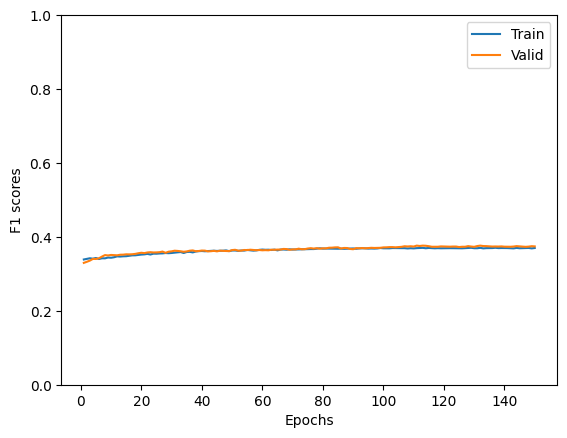

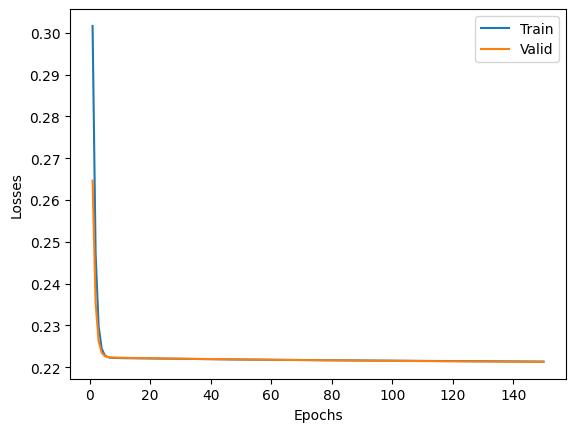

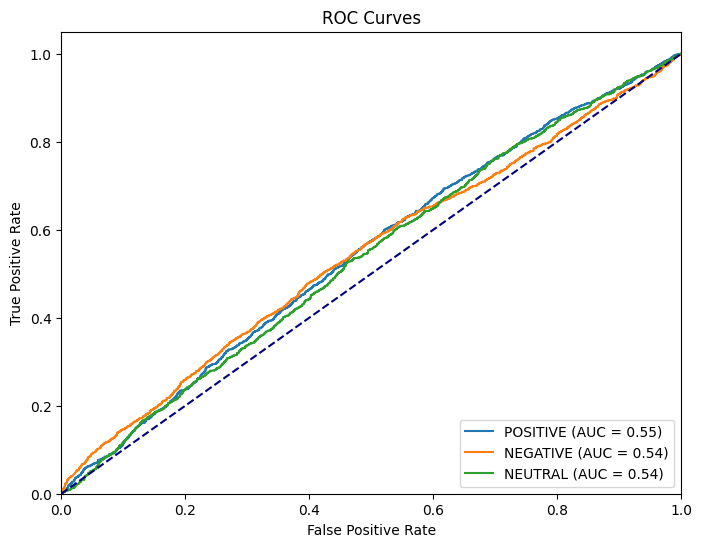

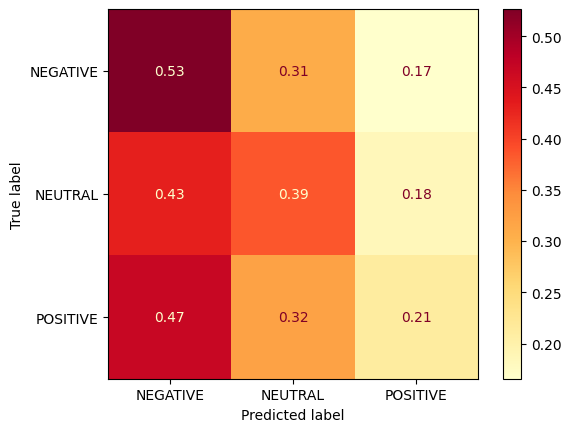

In [19]:
# This is the Brute Force aproach
# We have one hidden layer with 64 nodes
#1e-3 learning rate, MSE loss function, SGD optimizer and 64 batches
# it has not been preceded preprocessing

#Define layer size
D_in = XtrainVectorized_without_preprocess.shape[1] 
H1 = 64
D_out = 3 

#Define Hyperparameters
learning_rate = 1e-3
batch_number = 64

#Initialise model, loss, optimizer
neural_network_model = Brute_Force_Net(D_in, H1,D_out).to(compute_unit)
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(neural_network_model.parameters(), lr=learning_rate)

#Initialise datasets and dataloaders
TrainDataset = torch.utils.data.TensorDataset(XtrainTensor_without_preprocess, YtrainTensor) 
TrainDataloader = torch.utils.data.DataLoader(TrainDataset, batch_size=batch_number, shuffle=True) 

ValDataset = torch.utils.data.TensorDataset(XvalTensor_without_preprocess, YvalTensor) 
ValDataloader = torch.utils.data.DataLoader(ValDataset, batch_size=batch_number, shuffle=True) 

#train model
epochs = 150
model_train(TrainDataloader, ValDataloader, neural_network_model, loss_func, optimizer, compute_unit,epochs)

# plot ROC Curves and Confusion matrices
plot_roc_curve_confusion_matrix(neural_network_model,XvalTensor_without_preprocess,Yval)





# K Fold Cross Validation

------------fold no---------0----------------------
------------fold no---------1----------------------
------------fold no---------2----------------------
------------fold no---------3----------------------
------------fold no---------4----------------------


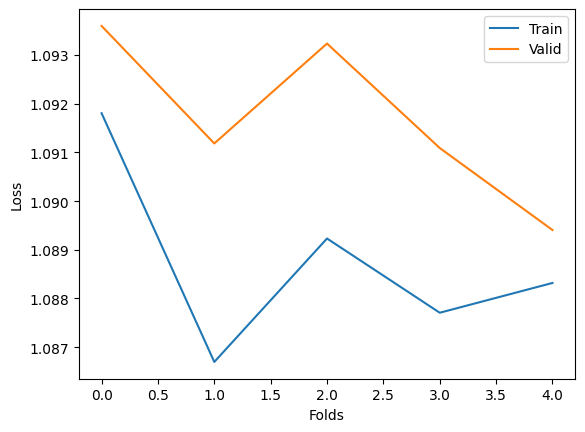

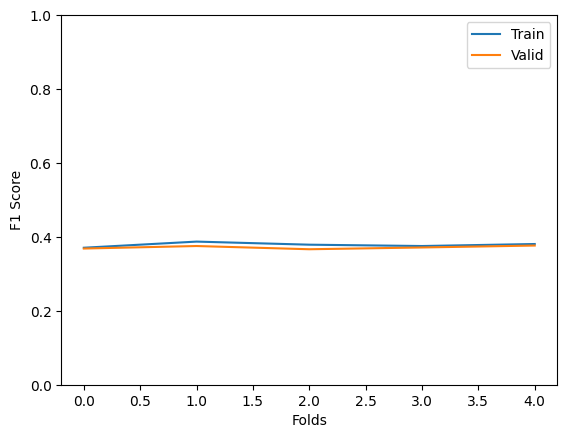

In [20]:
# We use Kfold cross validation in order to get a more robust estimation of the neural network's performance.

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
VectorizedDataset = np.concatenate((XtrainVectorized, XvalVectorized), axis=0)
whole_Y = np.concatenate((Ytrain, Yval), axis=0)

average_f1_train_scores = []
average_f1_val_scores = []
average_train_losses = []
average_val_losses = []

#Define layer sizes
D_in = VectorizedDataset.shape[1] 
H1 = 64
H2 = 32
H3 = 16
H4 = 8
D_out = 3


for fold,(train_idx,test_idx) in enumerate(kfold.split(VectorizedDataset)):
    print('------------fold no---------{}----------------------'.format(fold))
    batch_number = 2048
    learning_rate = 1e-4
    loss_func = nn.CrossEntropyLoss()
    epochs = 150
    dropout = 0.2
    
    neural_network_model = Net(D_in, H1, H2, H3,H4, D_out,nn.ReLU(inplace=True),dropout).to(compute_unit)
    optimizer = torch.optim.Adam(neural_network_model.parameters(), lr=learning_rate)

    # Get training and Validation Set    
    XtrainVectorized_kfold = VectorizedDataset[train_idx]
    XvalVectorized_kfold = VectorizedDataset[test_idx]
    Ytrain_kfold = whole_Y[train_idx]
    Yval_kfold = whole_Y[test_idx]
    
    #save to tensors\n",
    XtrainTensor_kfold, YtrainTensor_kfold, XvalTensor_kfold, YvalTensor_kfold = Save_to_tensors(XtrainVectorized_kfold, Ytrain_kfold, XvalVectorized_kfold, Yval_kfold, compute_unit)

    TrainDataset = torch.utils.data.TensorDataset(XtrainTensor_kfold, YtrainTensor_kfold) 
    ValDataset = torch.utils.data.TensorDataset(XvalTensor_kfold, YvalTensor_kfold)
    
    trainloader = torch.utils.data.DataLoader(TrainDataset,batch_size=batch_number, shuffle=True)
    valloader = torch.utils.data.DataLoader(ValDataset,batch_size=batch_number, shuffle=True)
    
    #train model
    f1_valid,f1_train_scores,f1_valid_scores ,train_losses,valid_losses= model_train(trainloader, valloader, neural_network_model, loss_func, optimizer, compute_unit,epochs,k_fold=True)
    
    average_f1_train_score = np.mean(f1_train_scores)
    average_f1_val_score = np.mean(f1_valid_scores)
    average_train_loss = np.mean(train_losses)
    average_val_loss = np.mean(valid_losses)
    
    average_f1_train_scores.append(average_f1_train_score)
    average_f1_val_scores.append(average_f1_val_score)
    average_train_losses.append(average_train_loss)
    average_val_losses.append(average_val_loss)
    
    
# Plot Losses
plt.plot(average_train_losses, label="Train Loss")
plt.plot(average_val_losses, label="Val Loss")
plt.xlabel("Folds")
plt.ylabel("Loss")
plt.legend(["Train", "Valid"])
plt.show()

# Plot F1 Scores
plt.plot(average_f1_train_scores, label="Train F1 Score")
plt.plot(average_f1_val_scores, label="Validation F1 Score")
plt.xlabel("Folds")
plt.ylabel("F1 Score")
plt.ylim(ymin=0.0, ymax=1.0)
plt.legend(["Train", "Valid"])
plt.show()

# Final Model

Epoch:  1  Train Loss:  1.1018891268306308  Validation Loss:  1.1013247569402058  Train F1:  0.33276003276003274  Validation F1:  0.3333333333333333
Epoch:  2  Train Loss:  1.1009181208080716  Validation Loss:  1.1005932887395222  Train F1:  0.3333333333333333  Validation F1:  0.3333333333333333
Epoch:  3  Train Loss:  1.1004755232069228  Validation Loss:  1.100340723991394  Train F1:  0.3333333333333333  Validation F1:  0.3333333333333333
Epoch:  4  Train Loss:  1.1000733375549316  Validation Loss:  1.1001200675964355  Train F1:  0.3333333333333333  Validation F1:  0.3333333333333333
Epoch:  5  Train Loss:  1.0997028681966994  Validation Loss:  1.099698265393575  Train F1:  0.3343980343980344  Validation F1:  0.3348623853211009
Epoch:  6  Train Loss:  1.0993522140714858  Validation Loss:  1.0991519292195637  Train F1:  0.3378105378105378  Validation F1:  0.3407874617737003
Epoch:  7  Train Loss:  1.0989938577016194  Validation Loss:  1.0988390843073528  Train F1:  0.3438984438984439  

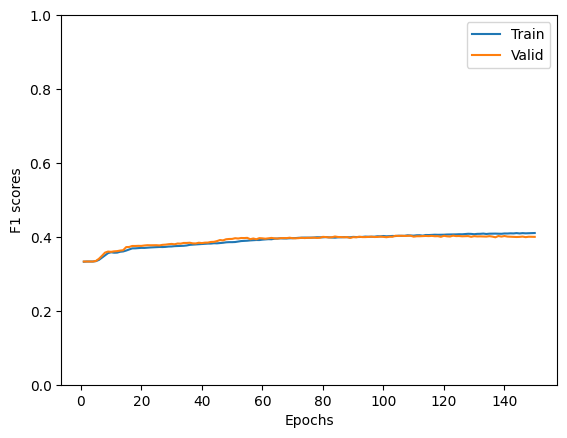

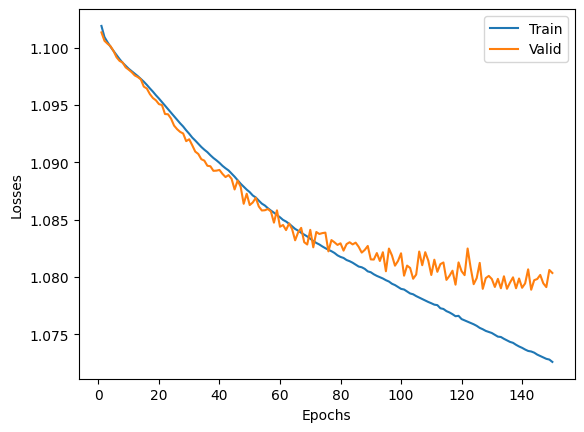

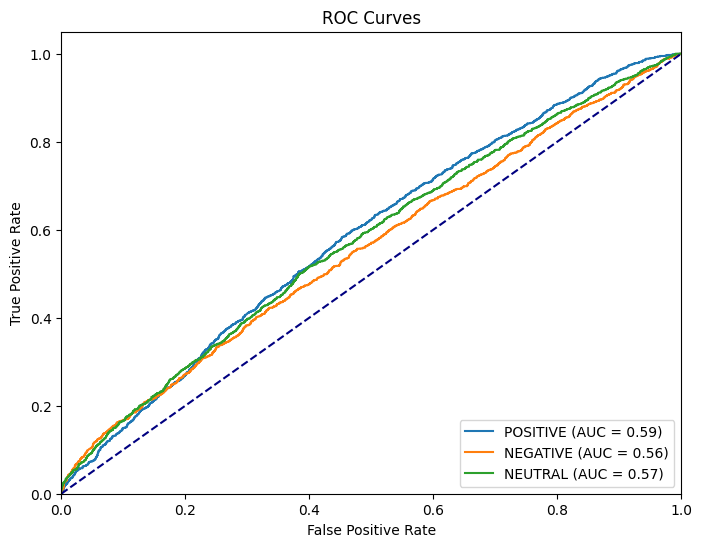

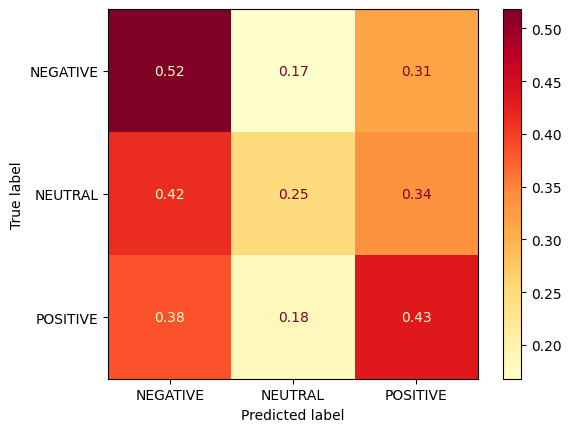

In [21]:
# Here is the final model
# We have:
# 4 hidden layers with 64,32,16,8 nodes in each layer respectively
# 1e-4 learning rate
# 2048 batches
# ReLU activation function
# CrossEntropyLoss loss function
# Adam Optimizer
# 0.3 dropout rate

#Define layer sizes
D_in = XtrainVectorized.shape[1] 
H1 = 64
H2 = 32
H3 = 16
H4 = 8
D_out = 3

torch.manual_seed(42)

#Define Hyperparameters and initialize loss func and activation function
learning_rate = 1e-4
batch_number = 2048
dropout = 0.3
loss_func = nn.CrossEntropyLoss()
activ_func = nn.ReLU(inplace=True)


#Initialise model,optimizer
neural_network_model = Net(D_in, H1, H2, H3,H4, D_out,activ_func,dropout=dropout).to(compute_unit)
optimizer = torch.optim.Adam(neural_network_model.parameters(), lr=learning_rate)
    
#Initialise datasets and dataloaders
TrainDataset = torch.utils.data.TensorDataset(XtrainTensor, YtrainTensor) 
TrainDataloader = torch.utils.data.DataLoader(TrainDataset, batch_size=batch_number, shuffle=True) 

ValDataset = torch.utils.data.TensorDataset(XvalTensor, YvalTensor) 
ValDataloader = torch.utils.data.DataLoader(ValDataset, batch_size=batch_number, shuffle=True) 

#train model
epochs = 150
model_train(TrainDataloader, ValDataloader, neural_network_model, loss_func, optimizer, compute_unit,epochs)

# plot ROC Curves and Confusion Matrices
plot_roc_curve_confusion_matrix(neural_network_model,XvalTensor,Yval)

# Predict the TestSet

In [22]:
# Predict the TestSet
with torch.no_grad():
    neural_network_model.eval()
    Ytest_predict = neural_network_model(XtestTensor)
    
# Convert it to the right form
Ytest_predict = torch.argmax(Ytest_predict, axis=1)
Ytest_pred_initial = np.zeros(shape=(Ytest_predict.shape[0],3))
Ytest_pred_initial[np.arange(len(Ytest_predict.cpu())), Ytest_predict.cpu()] = 1
Ytest_pred_initial = encoder.inverse_transform(Ytest_pred_initial)  

submission_df = pd.DataFrame({"Id": TestSet["New_ID"], "Predicted":Ytest_pred_initial})
submission_df.to_csv('submission.csv', index=False)

# CBOW approach

Epoch:  1  Train Loss:  1.111369424396091  Validation Loss:  1.1103446086247761  Train F1:  0.3333333333333333  Validation F1:  0.3333333333333333
Epoch:  2  Train Loss:  1.1110335257318285  Validation Loss:  1.1108909050623577  Train F1:  0.3333333333333333  Validation F1:  0.3333333333333333
Epoch:  3  Train Loss:  1.1102267768647935  Validation Loss:  1.1090413729349773  Train F1:  0.3333333333333333  Validation F1:  0.3333333333333333
Epoch:  4  Train Loss:  1.1094818380143907  Validation Loss:  1.1095884243647258  Train F1:  0.3333333333333333  Validation F1:  0.3333333333333333
Epoch:  5  Train Loss:  1.1087531911002264  Validation Loss:  1.1084257364273071  Train F1:  0.3333333333333333  Validation F1:  0.3333333333333333
Epoch:  6  Train Loss:  1.1080708172586229  Validation Loss:  1.1077985763549805  Train F1:  0.3333333333333333  Validation F1:  0.3333333333333333
Epoch:  7  Train Loss:  1.1073391834894817  Validation Loss:  1.1074857314427693  Train F1:  0.3333333333333333  

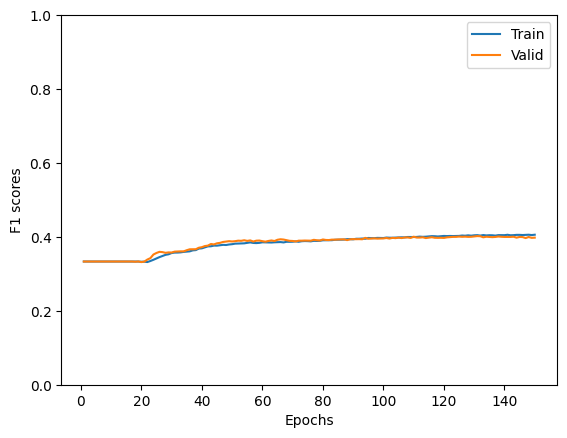

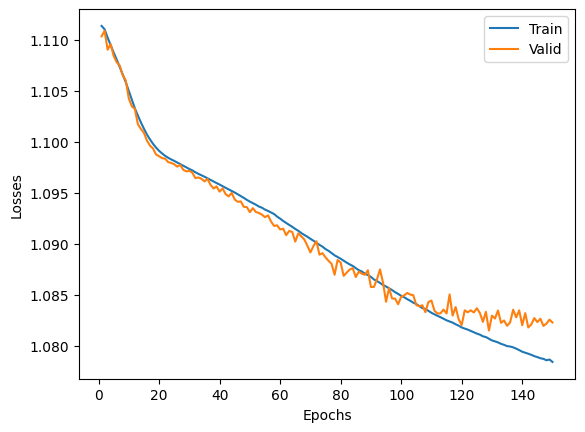

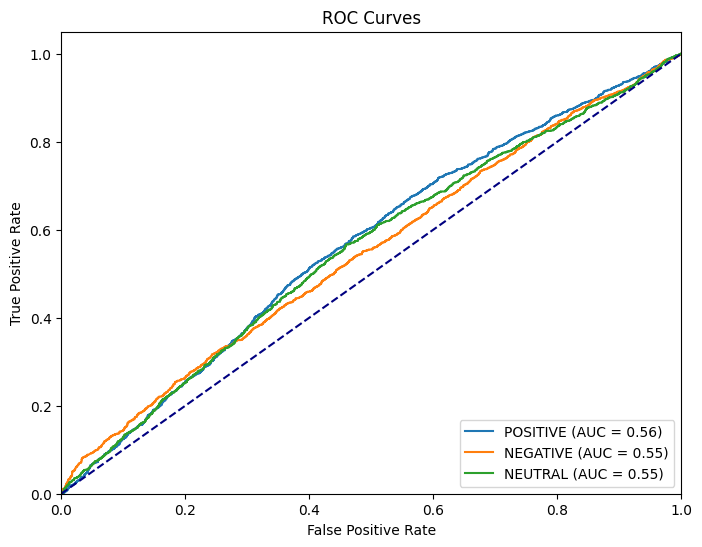

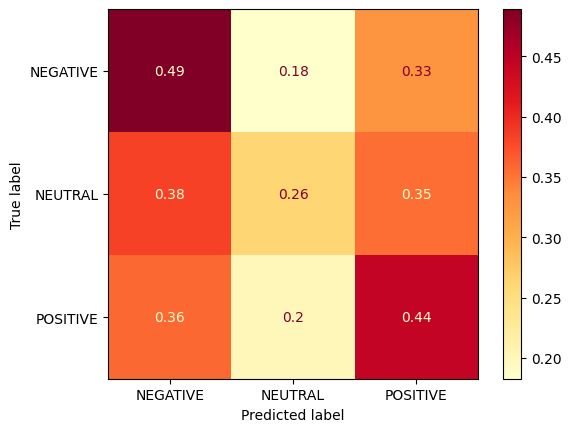

In [23]:
# Here is the final model Vectorized with CBOW
# We have:
# 4 hidden layers with 64,32,16,8 nodes in each layer respectively
# 1e-4 learning rate
# 2048 batches
# ReLU activation function
# CrossEntropyLoss loss function
# Adam Optimizer
# 0.3 dropout rate

#Define layer sizes
D_in = XtrainVectorized_CBOW.shape[1] 
H1 = 64
H2 = 32
H3 = 16
H4 = 8
D_out = 3

#Define Hyperparameters
learning_rate = 1e-4 
batch_number = 2048
dropout = 0.3

#Initialise model, loss, optimizer
neural_network_model = Net(D_in, H1, H2, H3,H4, D_out,nn.ReLU(inplace=True),dropout=dropout).to(compute_unit)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(neural_network_model.parameters(), lr=learning_rate)



#Initialise datasets and dataloaders
TrainDataset = torch.utils.data.TensorDataset(XtrainTensor_CBOW, YtrainTensor) 
TrainDataloader = torch.utils.data.DataLoader(TrainDataset, batch_size=batch_number, shuffle=True) 

ValDataset = torch.utils.data.TensorDataset(XvalTensor_CBOW, YvalTensor) 
ValDataloader = torch.utils.data.DataLoader(ValDataset, batch_size=batch_number, shuffle=True) 

#Train model
epochs = 150
model_train(TrainDataloader, ValDataloader, neural_network_model, loss_func, optimizer, compute_unit,epochs)

# Plot ROC Curves and Confusion Matrices
plot_roc_curve_confusion_matrix(neural_network_model,XvalTensor_CBOW,Yval)

# Optuna Framework

In [24]:
trial_number = -1

def optimize_hyperparameters(trial):   
    global trial_number  
    trial_number += 1
    print("Trial Number: ", trial_number)
    print("\n")

    batch_number = trial.suggest_categorical(name='batch_number', choices=[64,128,256,512,1024,2048,4096])
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    

    #Define layer sizes
    D_in = XtrainVectorized.shape[1] 
    H1 = 64
    H2 = 32
    H3 = 16
    H4 = 8
    D_out = 3

    #Define Hyperparameters
    learning_rate = 1e-4 
    
    
    neural_network_model = Net(D_in, H1, H2, H3,H4, D_out,nn.ReLU(inplace=True),dropout=dropout).to(compute_unit)
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(neural_network_model.parameters(), lr=learning_rate)

    #Initialise dataloader
    TrainDataset = torch.utils.data.TensorDataset(XtrainTensor, YtrainTensor) 
    TrainDataloader = torch.utils.data.DataLoader(TrainDataset, batch_size=batch_number, shuffle=True) 

    ValDataset = torch.utils.data.TensorDataset(XvalTensor, YvalTensor) 
    ValDataloader = torch.utils.data.DataLoader(ValDataset, batch_size=batch_number, shuffle=True) 


    #train model
    epochs = 50
    f1_valid,list_of_f1_scores_train,list_of_f1_scores_valid,list_of_train_losses,list_of_valid_losses = model_train(TrainDataloader, ValDataloader, neural_network_model, loss_func, optimizer, compute_unit,epochs)

    return f1_valid

# use optuna framework to find the best hyperparameters for batch size and dropout rate
if use_optuna == True: 
    study = optuna.create_study(direction="maximize")
    study.optimize(optimize_hyperparameters, n_trials=50)
